In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import cholesky, eigvals
from scipy import stats
from scipy.optimize import minimize 
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
import time

Problem 1:

Use the data in problem1.csv. Fit a Normal Distribution and a Generalized T distribution to this data. Calculate the VaR and ES for both fitted distributions.

Overlay the graphs the distribution PDFs, VaR, and ES values. What do you notice? Explain the differences.

Problem 1.1

Use the data in problem1.csv. Fit a Normal Distribution and a Generalized T distribution to this data. Calculate the VaR and ES for both fitted distributions.

In [2]:
problem1 = pd.read_csv('problem1.csv')

In [3]:
def cal_VaR_ES_norm(returns, n=10000, alpha=0.05):
    mu = returns.mean()
    sigma = returns.std()
    simu_returns = np.random.normal(mu, sigma, n)
    simu_returns.sort()
    n = alpha * simu_returns.size
    iup = int(np.ceil(n))
    idn = int(np.floor(n))
    VaR = (simu_returns[iup] + simu_returns[idn]) / 2

    ES = np.mean(simu_returns[0:idn])

    return -VaR, -ES, simu_returns

In [4]:
def MLE_t(params, returns):
    df, loc, scale = params
    neg_LL = -1 * np.sum(stats.t.logpdf(returns, df=df, loc=loc, scale=scale))
    return(neg_LL)

def cal_VaR_MLE_t(returns, n=10000, alpha=0.05):
    constraints = [
        {'type': 'ineq', 'fun': lambda x: x[0] - 1},
        {'type': 'ineq', 'fun': lambda x: x[2]}
    ]
    
    res = minimize(MLE_t, x0=[10, returns.mean(), returns.std()], args=(returns,), constraints=constraints)
    
    df, loc, scale = res.x
    simu_returns = stats.t.rvs(df, loc=loc, scale=scale, size=n)
    simu_returns.sort()
    n = alpha * simu_returns.size
    iup = int(np.ceil(n))
    idn = int(np.floor(n))
    VaR = (simu_returns[iup] + simu_returns[idn]) / 2

    ES = np.mean(simu_returns[0:idn])

    return -VaR, -ES, simu_returns

In [5]:
VaR_norm, ES_norm, simu_norm = cal_VaR_ES_norm(problem1)
VaR_t, ES_t, simu_t = cal_VaR_MLE_t(problem1)
print("VaR_norm is {}, ES_norm is {},VaR_t is {},ES_t is {}".format(VaR_norm, ES_norm, VaR_t, ES_t))

VaR_norm is 0.08361068311762304, ES_norm is 0.1048173746507498,VaR_t is 0.07824414571691295,ES_t is 0.11403585253520747


/Users/wangyuanzhe/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:496: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x0 = np.asarray(x0)


Problem 1.2

Overlay the graphs the distribution PDFs, VaR, and ES values. What do you notice? Explain the differences.

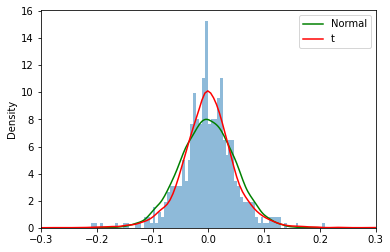

In [6]:
plt.hist(problem1, bins=80, density=True, alpha=0.5)
sns.kdeplot(simu_norm, label='Normal', color='g')
sns.kdeplot(simu_t, label='t', color='r')
plt.xlim(-0.3, 0.3)
plt.legend()
plt.show()

Problem 2:

In your main repository, create a Library for risk management. Create modules, classes, packages, etc as you see fit. Include all the functionality we have discussed so far in class. Make sure it includes

1. Covariance estimation techniques.

2. Non PSD fixes for correlation matrices

3. Simulation Methods

4. VaR calculation methods (all discussed)

5. ES calculation

Create a test suite and show that each function performs as expected.

In [7]:
import quant_risk_mgmt as qrm

In [8]:
df = pd.read_csv("DailyPrices.csv")

# Calculate return
df_return = qrm.return_calculate(df)
df_return.drop('Date', axis=1, inplace=True)

/Users/wangyuanzhe/Desktop/Y1S2/Fintech545/Week05/quant_risk_mgmt.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[vars[i]] = p2[:,i]


1. Covariance estimation techniques Test.

In [9]:
ew_cov = qrm.exp_weighted_cov(df_return)
pd.DataFrame(ew_cov)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000155,0.000210,0.000235,0.000285,0.000279,0.000279,0.000284,0.000331,0.000368,0.000125,...,0.000172,0.000082,0.000052,0.000197,0.000042,0.000034,0.000171,0.000209,0.000160,0.000063
1,0.000210,0.000421,0.000321,0.000329,0.000526,0.000417,0.000417,0.000563,0.000527,0.000152,...,0.000182,0.000084,0.000039,0.000286,0.000087,0.000035,0.000222,0.000286,0.000201,0.000064
2,0.000235,0.000321,0.000499,0.000505,0.000438,0.000521,0.000529,0.000664,0.000610,0.000166,...,0.000220,0.000084,0.000042,0.000291,-0.000003,0.000032,0.000224,0.000297,0.000192,0.000038
3,0.000285,0.000329,0.000505,0.000939,0.000542,0.000657,0.000671,0.000923,0.000696,0.000200,...,0.000277,0.000128,0.000050,0.000336,-0.000115,-0.000016,0.000296,0.000436,0.000266,0.000039
4,0.000279,0.000526,0.000438,0.000542,0.002369,0.000434,0.000444,0.000636,0.001212,0.000119,...,0.000292,0.000079,0.000004,0.000381,0.000004,0.000066,0.000252,0.000666,0.000179,0.000075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000034,0.000035,0.000032,-0.000016,0.000066,-0.000019,-0.000017,-0.000049,0.000013,0.000046,...,0.000048,0.000044,0.000033,0.000022,0.000087,0.000163,-0.000025,0.000052,-0.000003,0.000064
96,0.000171,0.000222,0.000224,0.000296,0.000252,0.000307,0.000307,0.000380,0.000468,0.000106,...,0.000168,0.000131,0.000194,0.000257,0.000034,-0.000025,0.000531,0.000186,0.000205,0.000082
97,0.000209,0.000286,0.000297,0.000436,0.000666,0.000325,0.000330,0.000615,0.000536,0.000165,...,0.000230,0.000097,0.000028,0.000250,0.000041,0.000052,0.000186,0.000716,0.000213,0.000064
98,0.000160,0.000201,0.000192,0.000266,0.000179,0.000279,0.000284,0.000361,0.000300,0.000142,...,0.000245,0.000092,0.000073,0.000186,0.000048,-0.000003,0.000205,0.000213,0.000325,0.000072


2. Non PSD fixes for correlation matrices test.

In [10]:
n = 500
sigma = np.full((n,n),0.9)
for i in range(n):
    sigma[i,i]=1.0
sigma[0,1] = 0.7357
sigma[1,0] = 0.7357

In [11]:
print("Sigma: ", qrm.is_psd(sigma))
print("Sigma fixed with near_psd(): ", qrm.is_psd(qrm.near_psd(sigma)))
print("Sigma fixed with Higham_psd(): ", qrm.is_psd(qrm.Higham_psd(sigma)))

Sigma:  False
Sigma fixed with near_psd():  True
Sigma fixed with Higham_psd():  True


3. Simulation Methods test.

In [12]:
pd.DataFrame(qrm.multivar_norm_simu(ew_cov))

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.014829,0.016226,0.033257,0.017360,0.003663,0.040387,0.038326,0.088741,0.028594,0.010139,...,0.014674,-0.001802,-0.001388,0.016465,-0.008457,0.011058,0.013040,0.010715,0.019616,-0.012559
1,0.015473,0.029864,0.011883,0.006704,0.009540,0.014637,0.013921,-0.020782,0.006120,0.017023,...,0.040987,0.021598,0.002710,0.015581,-0.002095,0.007481,0.024537,0.015158,0.032190,0.028156
2,-0.002213,-0.007624,-0.010959,0.027477,-0.027866,-0.020682,-0.020723,0.017387,-0.037403,-0.002024,...,-0.005014,0.020232,0.014782,-0.005411,-0.004735,0.005844,0.006554,-0.032568,-0.013243,0.021523
3,-0.005129,-0.031671,0.000321,-0.016059,-0.015273,-0.019132,-0.017404,-0.088154,0.025050,-0.008101,...,-0.015390,-0.021396,-0.010896,-0.009785,-0.015843,-0.008009,0.006423,-0.017152,-0.006874,-0.016436
4,-0.003958,-0.024212,-0.003665,-0.020465,-0.044337,0.006029,0.004745,-0.015614,-0.044435,-0.001682,...,-0.008150,-0.013236,0.011060,-0.011248,0.000545,-0.006246,0.010519,-0.012886,0.011772,0.000163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,-0.001348,-0.009855,0.024870,0.001869,-0.040726,-0.008878,-0.009549,-0.018640,-0.002185,0.001909,...,-0.005947,0.006062,0.022138,-0.003916,-0.009949,-0.000422,0.006652,-0.022239,-0.006906,0.013657
24996,0.013673,0.009247,0.040262,0.025505,-0.034666,0.042487,0.041467,0.060863,0.012376,0.023834,...,0.013384,0.001553,0.009302,0.004619,-0.007912,-0.001241,0.010162,0.015417,0.012684,0.001053
24997,-0.002857,0.002351,0.009040,-0.015513,0.011909,0.004240,0.001627,0.009816,0.001910,-0.015208,...,-0.020031,0.000179,0.004022,-0.002969,-0.017020,-0.005501,0.017466,-0.016425,-0.009598,-0.011090
24998,-0.004012,-0.008637,0.013805,-0.031209,0.049394,0.004412,0.004673,0.028696,0.011606,-0.010684,...,-0.005168,-0.012878,-0.001985,-0.003230,-0.006191,-0.009787,0.021388,0.017021,-0.015822,-0.016392


In [13]:
pd.DataFrame(qrm.multivar_norm_simu(ew_cov, method='pca'))

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.004866,0.002769,-0.006516,-0.017782,0.044843,-0.032866,-0.032634,-0.013779,0.016995,-0.007233,...,0.008063,-0.001239,-0.005317,0.001824,-0.008003,-0.009933,-0.007572,0.010249,-0.023514,-0.006963
1,0.024366,0.027411,0.040697,0.086579,0.069133,0.014785,0.015497,0.035100,0.074685,0.010127,...,0.026296,0.018931,0.007141,0.027251,-0.019828,0.003267,0.026431,0.053183,0.016288,-0.007043
2,0.017075,0.029230,0.030638,0.036072,0.036308,0.035716,0.036448,0.080962,0.043359,-0.001138,...,0.024114,-0.000843,0.013351,0.027893,0.006773,-0.007163,0.015294,0.041817,0.013013,-0.024239
3,0.012024,0.012740,0.013795,0.026734,0.024312,0.022218,0.023498,0.012063,0.012026,0.012154,...,-0.020173,0.016626,0.021426,0.020555,0.021326,0.000229,0.020473,0.021221,0.032370,0.016841
4,0.002887,0.015775,0.008322,0.045603,0.035201,0.020373,0.021037,0.045534,-0.011346,0.004702,...,-0.019735,0.016883,0.019993,0.003531,0.006443,0.007024,0.033434,0.028754,-0.018925,0.007215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.022938,0.031893,0.044714,0.042618,0.078266,0.074721,0.075673,0.082823,0.070651,0.014501,...,0.051395,0.008499,0.001503,0.012289,-0.016970,-0.017216,0.031895,0.013799,0.030149,0.000864
24996,0.008159,0.029017,0.001614,-0.028453,-0.025487,0.012944,0.011761,0.011763,0.016312,0.008594,...,0.002827,0.003252,0.002214,0.022793,0.031706,0.012982,0.006449,-0.014589,0.006595,-0.007238
24997,0.013466,0.034862,0.014253,0.021859,0.037973,0.051824,0.052159,0.036135,0.028342,0.011319,...,0.005577,0.008797,-0.005588,0.024261,0.011071,-0.004379,0.009173,-0.030904,0.007459,-0.004199
24998,-0.018586,-0.043693,-0.011811,0.012947,0.009653,-0.002389,-0.002851,0.042841,-0.010030,-0.018249,...,-0.028143,-0.011024,-0.005346,-0.015043,-0.029621,-0.033133,0.014503,0.010730,-0.012482,-0.036539


In [14]:
#1. Pearson correlation and var
p_cov_var = qrm.p_cov_var_f(problem1)

In [15]:
#2. Pearson correlation and EW variance
p_corr_ew_var = qrm.p_corr_ew_var_f(problem1)

In [16]:
#3. EW(cov+corr) is exp_weighted_cov(input, lambda_)
ew_corr_cov = qrm.exp_weighted_cov(problem1)

In [17]:
#4. EW Corr +Var
ew_corr_p_var = qrm.ew_corr_p_var_f(problem1)

/Users/wangyuanzhe/Desktop/Y1S2/Fintech545/Week05/quant_risk_mgmt.py:232: RuntimeWarning: invalid value encountered in reciprocal
  asset_std = np.diag(np.reciprocal(np.sqrt(np.diag(cov))))


In [18]:
def time_and_error(covariance_matrix, method, explained_variance=1.0):
    
    start_time = time.time()
    samples = qrm.multivar_norm_simu(covariance_matrix, method=method, explained_variance=explained_variance)
    time_used = time.time() - start_time
    
    simulated_covariance = np.cov(samples, rowvar=False)
    error = qrm.Frobenius(simulated_covariance - covariance_matrix)
    
    return time_used, error

In [19]:
def simulate4(covariance_matrix):
    np.random.seed(0)
    variances = [1.0, 0.75, 0.5]
    
    time_used = []
    errors = []
    labels = []
    
    t, error = time_and_error(covariance_matrix, 'direct')
    time_used.append(t)
    errors.append(error)
    labels.append("direct")
    
    for var in variances:
        t, error = time_and_error(covariance_matrix, 'pca', var)
        time_used.append(t)
        errors.append(error)
        labels.append("PCA with {}".format(var))
            
    plt.plot(time_used, errors, 'r+')
    
    for i, label in enumerate(labels):
        plt.annotate(label, (time_used[i], errors[i]))
        
    plt.xlabel('Time used')
    plt.ylabel('Accuracy(Frobenius Norm)')

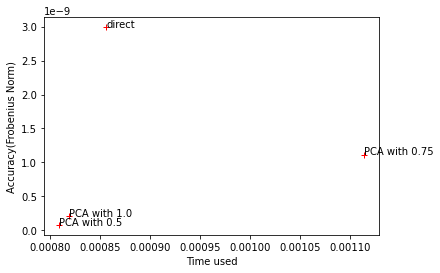

In [20]:
simulate4(p_corr_ew_var)

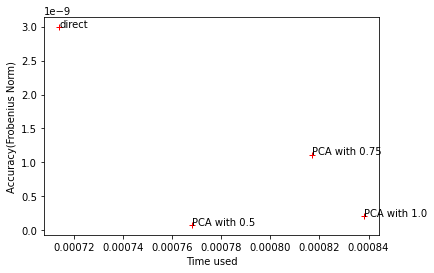

In [21]:
simulate4(ew_corr_cov)

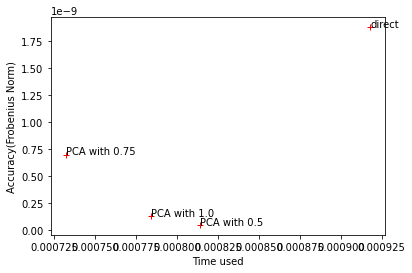

In [22]:
simulate4(ew_corr_p_var)

4. VaR calculation methods (all discussed) test.

In [23]:
qrm.cal_VaR_ES_norm(problem1)

(0.08003680616393635,
 0.1000233338941678,
 array([-0.19107711, -0.16378307, -0.1601868 , ...,  0.17383027,
         0.17628303,  0.189987  ]))

In [33]:
qrm.cal_VaR_ES_ew_norm(problem1)

ValueError: Output size (10000,) is not compatible with broadcast dimensions of inputs (1, 10000).

In [25]:
qrm.cal_VaR_MLE_t(problem1)

/Users/wangyuanzhe/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:496: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x0 = np.asarray(x0)


(0.07622763968521143,
 0.11153381427440978,
 array([-0.4432504 , -0.35196577, -0.335702  , ...,  0.41938084,
         0.44282639,  0.44392566]))

In [27]:
qrm.cal_VaR_AR1(problem1)

(0.07827760655043352,
 0.09873493222233498,
 array([-0.21264625, -0.19206341, -0.19019727, ...,  0.1778189 ,
         0.18559086,  0.18858338]))

In [28]:
qrm.cal_VaR_hist(problem1)

KeyError: 25

In [29]:
portfolio = pd.read_csv("portfolio.csv")
prices = pd.read_csv("DailyPrices.csv")
Total_Value_A, assets_prices_A, holdings_A, delta_A = qrm.get_single_portfolio(portfolio, prices, "A")

In [30]:
qrm.cal_delta_VaR(Total_Value_A, assets_prices_A, delta_A)

5670.202920147334

In [31]:
qrm.calculate_MC_var(assets_prices_A, holdings_A)

5620.179270962247

In [32]:
qrm.cal_hist_VaR(assets_prices_A, holdings_A)

9138.874264224864

Problem 3:

Use your repository from #2.

Using Portfolio.csv and DailyPrices.csv. Assume the expected return on all stocks is 0. This file contains the stock holdings of 3 portfolios. You own each of these portfolios.

Fit a Generalized T model to each stock and calculate the VaR and ES of each portfolio as well as your total VaR and ES. Compare the results from this to your VaR form Problem 3 from Week 4.